## Install required packages

In [92]:
import locale
print(locale.getpreferredencoding())
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())


UTF-8
UTF-8


In [93]:
!pip install calflops
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
# !pip install onnx onnxruntime
# !git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .

In [94]:
# import sys
# sys.path.append("./onnx-tensorflow")

In [95]:
# !pip install onnx-simplifier

In [96]:
# !wget https://github.com/PINTO0309/onnx2tf/releases/download/1.16.31/flatc.tar.gz \
#   && tar -zxvf flatc.tar.gz \
#   && sudo chmod +x flatc \
#   && sudo mv flatc /usr/bin/
# !pip install -U pip \
#   && pip install -U onnx>=1.14.1 \
#   && python -m pip install onnx_graphsurgeon \
#         --index-url https://pypi.ngc.nvidia.com \
#   && pip install -U onnxruntime==1.16.0 \
#   && pip install -U onnxsim==0.4.33 \
#   && pip install -U simple_onnx_processing_tools \
#   && pip install -U onnx2tf \
#   && pip install -U protobuf==3.20.3 \
#   && pip install -U h5py==3.7.0 \
#   && pip install -U psutil==5.9.5 \
#   && pip install -U ml_dtypes==0.2.0

In [97]:
!pip install -U coremltools

In [128]:
import torch
import numpy as np
import random
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


## Prepare data

In [129]:
def prepare_data(directory = "./data"):
  # Initialize an empty list to store the data
  data = []

  # List of CSV files
  csv_files = ["Attack.csv", "Jump.csv", "Left.csv", "Right.csv"]

  # Loop through each file
  for file in csv_files:
      # Construct the full path to the file
      file_path = os.path.join(directory, file)

      # Read the CSV file, skipping empty rows (which are interpreted as NaN)
      df = pd.read_csv(file_path, header=0, usecols=[0,1,2,3,4,5])

      # Drop NaN rows
      df = df.dropna()
    #   df['aX'] = (df['aX']+4)/8
    #   df['aY'] = (df['aY']+4)/8
    #   df['aZ'] = (df['aZ']+4)/8

    #   df['gX'] = (df['gX']+2000)/4000
    #   df['gY'] = (df['gY']+2000)/4000
    #   df['gZ'] = (df['gZ']+2000)/4000

      # Split the dataframe into samples of 119 rows each
      for i in range(0, len(df), 50):
          sample = df.iloc[i:i+50]

          # Convert the sample dataframe to a numpy array
          sample_array = sample.to_numpy()

          # Get the label from the file name
          label = file.replace(".csv", "")

          # Append the label and data to the list
          data.append({'label': label, 'data': sample_array})

  # Create a final dataframe
  final_df = pd.DataFrame(data)
  print(f'There are {len(final_df.index)} samples in total.')

  labels = final_df["label"].unique()
  final_df["ClassID"] = encoder.fit_transform(final_df["label"])

  final_df["data"] = final_df["data"].apply(lambda x: x.transpose((1, 0)))
  return final_df

## Split original dataset into train and test set

In [130]:
df = prepare_data()

print(encoder.inverse_transform([0,1,2,3]))
print(df.iloc[0]["data"].shape)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Number of training set: {len(df_train.index)}")
print(f"Number of test set: {len(df_test.index)}")

## Make hardcode data file just for sharing

import os
import pandas as pd

def save_to_csv(df, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for index, row in df.iterrows():
        data = row['data'].T

        # data[:, 0] = (data[:, 0] * 8) - 4
        # data[:, 1] = (data[:, 1] * 8) - 4
        # data[:, 2] = (data[:, 2] * 8) - 4
        # data[:, 3] = (data[:, 3] * 4000) - 2000
        # data[:, 4] = (data[:, 4] * 4000) - 2000
        # data[:, 5] = (data[:, 5] * 4000) - 2000

        data_df = pd.DataFrame(data, columns=['ax', 'ay', 'az', 'gx', 'gy', 'gz'])

        filename = f"{row['label']}.csv"
        filepath = os.path.join(directory, filename)

        if not os.path.isfile(filepath):
            data_df.to_csv(filepath, index=False)
        else:
            data_df.to_csv(filepath, mode='a', header=False, index=False)

save_to_csv(df_train, './data/train')
save_to_csv(df_test, './data/test')


There are 200 samples in total.
['Attack' 'Jump' 'Left' 'Right']
(6, 50)
Number of training set: 160
Number of test set: 40


In [131]:
!tar -czvf data.tar.gz ./data

./data/
./data/train/
./data/train/Attack.csv
./data/train/Jump.csv
./data/train/Left.csv
./data/train/Right.csv
./data/Attack.csv
./data/test/
./data/test/Attack.csv
./data/test/Jump.csv
./data/test/Left.csv
./data/test/Right.csv
./data/Jump.csv
./data/Left.csv
./data/Right.csv


In [132]:
# !rm -rf data/test
# !rm -rf data/train

## Load test and train data for experiments 🌟

In [133]:
df_train_loaded = prepare_data('./data/train')

# You want to change test dataset here. We assume there is no data normalization and standradlization in ./data/test/*.csv. We do data transformations here.
df_test_loaded = prepare_data('./data/test')

There are 800 samples in total.
There are 200 samples in total.


## Prepare dataset

In [134]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [135]:


class GestureDataset(Dataset):
    def __init__(self, df, transform, preload=False, device='cpu'):
        self.df = df
        self.num_classes = self.df["ClassID"].nunique()
        self.transform = transform
        self.preload = preload
        self.data = []

        if self.preload:
            for index in tqdm(range(len(self.df.index)), f"Preloading dataset to {device}"):
                data = self.df.iloc[index]['data']
                data = torch.tensor(data, dtype=torch.float32)
                label = self.df.iloc[index]["ClassID"]

                data = data.to(device)  # Move to the specified device
                self.data.append((data, label))

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, index):
        if self.preload:
            return self.data[index]

        data = self.df.iloc[index]['data']
        data = torch.tensor(data, dtype=torch.float32)

        label = self.df.iloc[index]["ClassID"]

        return data, label

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Add data augmentations

In [137]:
import torch
import random
import numpy as np
from torchvision import transforms

class AddRandomNoise(object):
    def __init__(self, noise_level=0.05):
        self.noise_level = noise_level

    def __call__(self, data):
        noise = torch.randn_like(data) * self.noise_level
        return data + noise

class TimeWarp(object):
    def __init__(self, warp_factor=0.1):
        self.warp_factor = warp_factor

    def __call__(self, data):
        time_steps = data.shape[0]
        warp = np.random.uniform(1 - self.warp_factor, 1 + self.warp_factor)
        new_time_steps = int(time_steps * warp)
        data = torch.nn.functional.interpolate(data.view(1, 1, -1), size=new_time_steps, mode='linear', align_corners=False)
        return data.view(-1)

class ScaleTransform(object):
    def __init__(self, scale_factor=1.2):
        self.scale_factor = scale_factor

    def __call__(self, data):
        return data * self.scale_factor

# Define your transform pipeline
transform_train = transforms.Compose([
    # AddRandomNoise(noise_level=0.05),
    # TimeWarp(warp_factor=0.1),
    # ScaleTransform(scale_factor=1.2),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset and dataloaders
train_dataset = GestureDataset(df=df_train_loaded, transform=transform_train, preload=True, device=device)
test_dataset = GestureDataset(df=df_test_loaded, transform=transform_test, preload=True, device=device)


Preloading dataset to cuda: 100%|██████████| 200/200 [00:00<00:00, 4524.26it/s]


In [138]:
# set_seed(666)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

print(f'Num of classes: {train_dataset.num_classes}')
num_classes = train_dataset.num_classes
# Example: Print the shape of first batch data and labels
for data, labels in train_loader:
    print(data.shape,  labels.shape)
    break


Num of classes: 4
torch.Size([256, 6, 50]) torch.Size([256])


## Plot examples

In [139]:
feature_names = [
    'ax','ay','az',
    'gx','gy','gz',
]

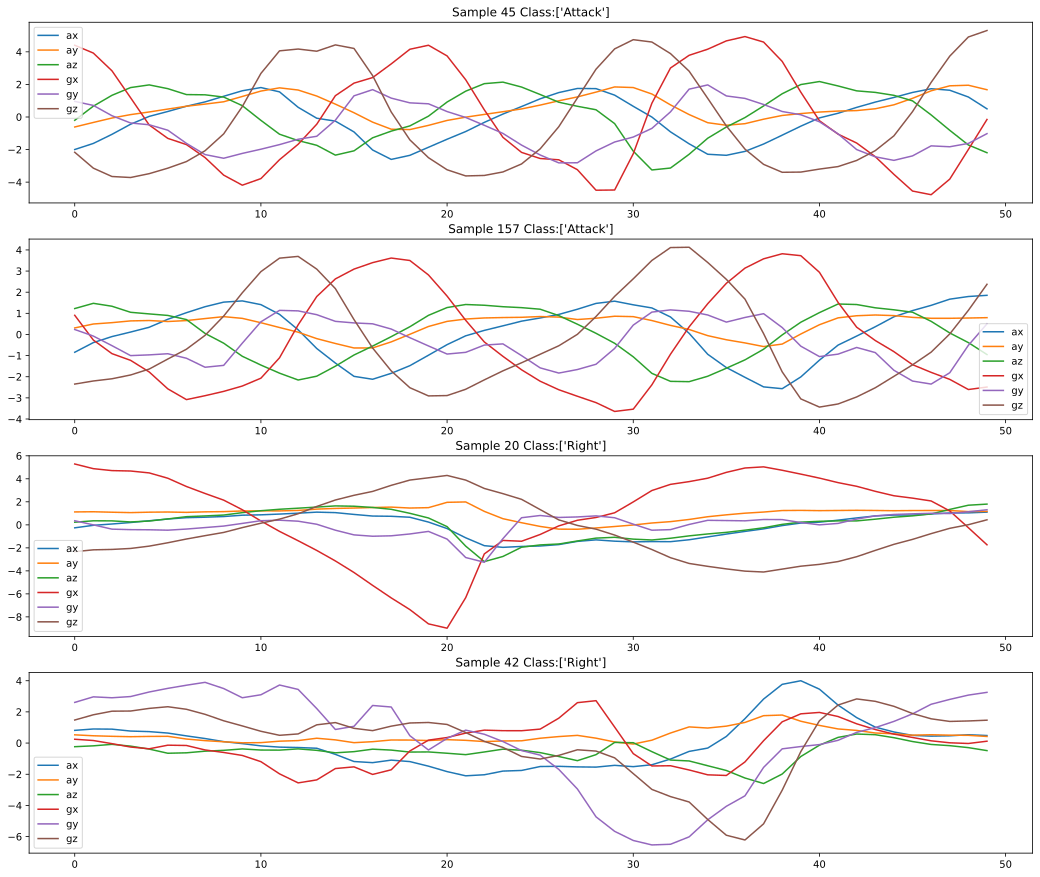

In [140]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
from matplotlib import pyplot as plt

sample = next(iter(train_loader))
sample_data = sample[0].permute(0, 2, 1)
sample_label = sample[1]

num_samples_to_plot = 4
indices = np.random.choice(sample_data.shape[0], num_samples_to_plot, replace=False)

plt.figure(figsize=(18, 15))

for i, index in enumerate(indices, 1):
    plt.subplot(num_samples_to_plot, 1, i)
    for j in range(sample_data.shape[2]):
        plt.plot(sample_data[index, :, j].cpu().numpy(), label=f'{feature_names[j]}')
    plt.legend()
    plt.title(f'Sample {index} Class:{encoder.inverse_transform([sample_label[index]])}')
    # plt.tight_layout()

plt.show()

## Define model

In [141]:
from torch import nn
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleTimeSeriesCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleTimeSeriesCNN, self).__init__()

        self.conv_block= nn.Sequential(
            nn.Conv1d(in_channels=6, out_channels=32, kernel_size=5, stride=1, padding=2),
            # 1x50x32
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            # 1x25x32

            #
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=4, stride=3, padding=1),
            # 1x8x32
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            # 1x4x32

            #
            # nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3),
            # nn.BatchNorm1d(16),
            # nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
        )

        self.fc = nn.Sequential(
            nn.Linear(4 * 16, num_classes), # 59
            # nn.ReLU(),
            # nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [142]:
from torch import nn
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F

class SimpleTimeSeriesCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleTimeSeriesCNN, self).__init__()
        self.conv_block= nn.Sequential(
            nn.Conv1d(in_channels=6, out_channels=32, kernel_size=5, stride=1, padding=2),
            # 1x50x32
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            # 1x25x32
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=4, stride=3, padding=1),
            # 1x8x32
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            # 1x4x32
        )

        self.fc = nn.Sequential(
            nn.Linear(4 * 16, num_classes), # 59
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Define training functions

In [143]:
from tqdm import tqdm
import random
import torchvision.transforms.functional as TF
def train(train_loader, model, criterion, optimizer, epoch, device):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_loader, "training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()


    train_accuracy = 100 * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

def test(test_loader, model, criterion, optimizer, epoch, device):

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
      for inputs,  labels in tqdm(test_loader, "testing"):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)

          loss = criterion(outputs, labels)
          test_loss += loss.item()

          _, predicted = outputs.max(1)
          test_total += labels.size(0)
          test_correct += (predicted == labels).sum().item()


      test_accuracy = 100 * test_correct / test_total
      avg_test_loss = test_loss / len(test_loader)
      print(f"Epoch {epoch+1}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")
      return test_accuracy/100


## Define helpers

In [144]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Train models

In [145]:
import time

In [146]:
lr = 1e-3
epochs =100

set_seed(42)
model = SimpleTimeSeriesCNN(num_classes=num_classes).to(device)
print(model)
print(f'The number of model parameters:{count_parameters(model)}')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

start_time = time.time()
for epoch in range(epochs):
  train(train_loader, model, criterion, optimizer, epoch, device)
  test_accuracy = test(test_loader, model, criterion, optimizer, epoch, device)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time} s")

print(f"Test accuracy :{test_accuracy*100}%")
print("Done")

SimpleTimeSeriesCNN(
  (conv_block): Sequential(
    (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 16, kernel_size=(4,), stride=(3,), padding=(1,))
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
  )
)
The number of model parameters:3412


training: 100%|██████████| 4/4 [00:00<00:00, 219.12it/s]


Epoch 1, Training Loss: 1.3201, Training Accuracy: 33.88%


testing:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
testing: 100%|██████████| 1/1 [00:00<00:00, 196.22it/s]


Epoch 1, Test Loss: 1.3249, Test Accuracy: 37.50%



training: 100%|██████████| 4/4 [00:00<00:00, 324.56it/s]


Epoch 2, Training Loss: 1.1090, Training Accuracy: 62.75%


testing: 100%|██████████| 1/1 [00:00<00:00, 397.53it/s]


Epoch 2, Test Loss: 1.1758, Test Accuracy: 55.00%



training: 100%|██████████| 4/4 [00:00<00:00, 319.00it/s]


Epoch 3, Training Loss: 0.9771, Training Accuracy: 78.88%


testing: 100%|██████████| 1/1 [00:00<00:00, 303.91it/s]


Epoch 3, Test Loss: 1.0739, Test Accuracy: 66.00%



training: 100%|██████████| 4/4 [00:00<00:00, 312.34it/s]


Epoch 4, Training Loss: 0.8881, Training Accuracy: 89.25%


testing: 100%|██████████| 1/1 [00:00<00:00, 371.05it/s]


Epoch 4, Test Loss: 0.9946, Test Accuracy: 72.50%



training: 100%|██████████| 4/4 [00:00<00:00, 320.81it/s]


Epoch 5, Training Loss: 0.8037, Training Accuracy: 91.38%


testing: 100%|██████████| 1/1 [00:00<00:00, 631.48it/s]


Epoch 5, Test Loss: 0.9153, Test Accuracy: 79.50%



training: 100%|██████████| 4/4 [00:00<00:00, 313.38it/s]


Epoch 6, Training Loss: 0.7050, Training Accuracy: 92.62%


testing: 100%|██████████| 1/1 [00:00<00:00, 349.96it/s]


Epoch 6, Test Loss: 0.8437, Test Accuracy: 82.50%



training: 100%|██████████| 4/4 [00:00<00:00, 273.61it/s]


Epoch 7, Training Loss: 0.6339, Training Accuracy: 93.88%


testing: 100%|██████████| 1/1 [00:00<00:00, 378.17it/s]


Epoch 7, Test Loss: 0.7804, Test Accuracy: 84.00%



training: 100%|██████████| 4/4 [00:00<00:00, 297.68it/s]


Epoch 8, Training Loss: 0.5735, Training Accuracy: 94.25%


testing: 100%|██████████| 1/1 [00:00<00:00, 310.41it/s]


Epoch 8, Test Loss: 0.7206, Test Accuracy: 86.50%



training: 100%|██████████| 4/4 [00:00<00:00, 293.97it/s]

Epoch 9, Training Loss: 0.5061, Training Accuracy: 94.62%



testing: 100%|██████████| 1/1 [00:00<00:00, 417.47it/s]


Epoch 9, Test Loss: 0.6634, Test Accuracy: 86.50%



training: 100%|██████████| 4/4 [00:00<00:00, 288.07it/s]


Epoch 10, Training Loss: 0.4720, Training Accuracy: 95.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 310.44it/s]


Epoch 10, Test Loss: 0.6074, Test Accuracy: 86.50%



training: 100%|██████████| 4/4 [00:00<00:00, 287.61it/s]


Epoch 11, Training Loss: 0.3870, Training Accuracy: 95.88%


testing: 100%|██████████| 1/1 [00:00<00:00, 289.38it/s]


Epoch 11, Test Loss: 0.5543, Test Accuracy: 93.00%



training: 100%|██████████| 4/4 [00:00<00:00, 275.85it/s]


Epoch 12, Training Loss: 0.3471, Training Accuracy: 96.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 319.18it/s]


Epoch 12, Test Loss: 0.5001, Test Accuracy: 94.00%



training: 100%|██████████| 4/4 [00:00<00:00, 272.18it/s]


Epoch 13, Training Loss: 0.3236, Training Accuracy: 96.88%


testing: 100%|██████████| 1/1 [00:00<00:00, 341.72it/s]

Epoch 13, Test Loss: 0.4501, Test Accuracy: 94.00%




training: 100%|██████████| 4/4 [00:00<00:00, 288.28it/s]


Epoch 14, Training Loss: 0.2698, Training Accuracy: 97.38%


testing: 100%|██████████| 1/1 [00:00<00:00, 277.11it/s]


Epoch 14, Test Loss: 0.4056, Test Accuracy: 95.00%



training: 100%|██████████| 4/4 [00:00<00:00, 275.49it/s]


Epoch 15, Training Loss: 0.2374, Training Accuracy: 98.38%


testing: 100%|██████████| 1/1 [00:00<00:00, 329.25it/s]


Epoch 15, Test Loss: 0.3617, Test Accuracy: 96.00%



training: 100%|██████████| 4/4 [00:00<00:00, 263.47it/s]


Epoch 16, Training Loss: 0.2145, Training Accuracy: 99.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 349.29it/s]


Epoch 16, Test Loss: 0.3273, Test Accuracy: 96.50%



training: 100%|██████████| 4/4 [00:00<00:00, 315.53it/s]


Epoch 17, Training Loss: 0.1769, Training Accuracy: 99.25%


testing: 100%|██████████| 1/1 [00:00<00:00, 376.98it/s]


Epoch 17, Test Loss: 0.3020, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 268.71it/s]


Epoch 18, Training Loss: 0.1618, Training Accuracy: 99.38%


testing: 100%|██████████| 1/1 [00:00<00:00, 360.40it/s]


Epoch 18, Test Loss: 0.2748, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 330.66it/s]


Epoch 19, Training Loss: 0.1412, Training Accuracy: 99.38%


testing: 100%|██████████| 1/1 [00:00<00:00, 359.38it/s]


Epoch 19, Test Loss: 0.2500, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 303.24it/s]


Epoch 20, Training Loss: 0.1177, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 347.07it/s]

Epoch 20, Test Loss: 0.2294, Test Accuracy: 99.50%




training: 100%|██████████| 4/4 [00:00<00:00, 307.96it/s]


Epoch 21, Training Loss: 0.1073, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 319.01it/s]


Epoch 21, Test Loss: 0.2122, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 282.15it/s]


Epoch 22, Training Loss: 0.1038, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 364.15it/s]


Epoch 22, Test Loss: 0.1987, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 308.00it/s]


Epoch 23, Training Loss: 0.0968, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 321.87it/s]


Epoch 23, Test Loss: 0.1868, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 298.86it/s]


Epoch 24, Training Loss: 0.0829, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 380.95it/s]


Epoch 24, Test Loss: 0.1767, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 335.34it/s]


Epoch 25, Training Loss: 0.0769, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 382.20it/s]


Epoch 25, Test Loss: 0.1672, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 259.51it/s]


Epoch 26, Training Loss: 0.0784, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 350.46it/s]


Epoch 26, Test Loss: 0.1571, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 317.82it/s]


Epoch 27, Training Loss: 0.0768, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 456.50it/s]


Epoch 27, Test Loss: 0.1468, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 271.48it/s]


Epoch 28, Training Loss: 0.0599, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 379.20it/s]


Epoch 28, Test Loss: 0.1379, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 303.06it/s]


Epoch 29, Training Loss: 0.0667, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 296.84it/s]


Epoch 29, Test Loss: 0.1306, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 262.48it/s]


Epoch 30, Training Loss: 0.0538, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 323.19it/s]


Epoch 30, Test Loss: 0.1253, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 312.16it/s]


Epoch 31, Training Loss: 0.0545, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 421.71it/s]


Epoch 31, Test Loss: 0.1213, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 273.74it/s]


Epoch 32, Training Loss: 0.0534, Training Accuracy: 99.38%


testing: 100%|██████████| 1/1 [00:00<00:00, 400.56it/s]


Epoch 32, Test Loss: 0.1185, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 301.14it/s]


Epoch 33, Training Loss: 0.0496, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 415.40it/s]


Epoch 33, Test Loss: 0.1171, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 306.03it/s]


Epoch 34, Training Loss: 0.0487, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 335.73it/s]


Epoch 34, Test Loss: 0.1133, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 296.77it/s]


Epoch 35, Training Loss: 0.0410, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 319.23it/s]


Epoch 35, Test Loss: 0.1089, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 303.85it/s]


Epoch 36, Training Loss: 0.0414, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 378.21it/s]


Epoch 36, Test Loss: 0.1041, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 270.26it/s]


Epoch 37, Training Loss: 0.0362, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 516.16it/s]


Epoch 37, Test Loss: 0.0994, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 278.60it/s]


Epoch 38, Training Loss: 0.0371, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 422.39it/s]


Epoch 38, Test Loss: 0.0953, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 333.47it/s]


Epoch 39, Training Loss: 0.0389, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 379.13it/s]


Epoch 39, Test Loss: 0.0924, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 309.66it/s]


Epoch 40, Training Loss: 0.0336, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 539.67it/s]


Epoch 40, Test Loss: 0.0900, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 282.64it/s]


Epoch 41, Training Loss: 0.0301, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 387.18it/s]


Epoch 41, Test Loss: 0.0884, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 284.33it/s]


Epoch 42, Training Loss: 0.0336, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 566.19it/s]


Epoch 42, Test Loss: 0.0869, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 308.61it/s]


Epoch 43, Training Loss: 0.0314, Training Accuracy: 99.50%


testing: 100%|██████████| 1/1 [00:00<00:00, 352.52it/s]


Epoch 43, Test Loss: 0.0852, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 229.57it/s]


Epoch 44, Training Loss: 0.0271, Training Accuracy: 99.62%


testing: 100%|██████████| 1/1 [00:00<00:00, 338.28it/s]


Epoch 44, Test Loss: 0.0834, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 253.71it/s]


Epoch 45, Training Loss: 0.0252, Training Accuracy: 99.62%


testing: 100%|██████████| 1/1 [00:00<00:00, 401.98it/s]


Epoch 45, Test Loss: 0.0821, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 300.27it/s]


Epoch 46, Training Loss: 0.0250, Training Accuracy: 99.75%


testing: 100%|██████████| 1/1 [00:00<00:00, 319.66it/s]


Epoch 46, Test Loss: 0.0807, Test Accuracy: 99.50%



training: 100%|██████████| 4/4 [00:00<00:00, 272.86it/s]


Epoch 47, Training Loss: 0.0244, Training Accuracy: 99.75%


testing: 100%|██████████| 1/1 [00:00<00:00, 429.04it/s]

Epoch 47, Test Loss: 0.0797, Test Accuracy: 100.00%




training: 100%|██████████| 4/4 [00:00<00:00, 279.03it/s]


Epoch 48, Training Loss: 0.0236, Training Accuracy: 99.75%


testing: 100%|██████████| 1/1 [00:00<00:00, 307.57it/s]


Epoch 48, Test Loss: 0.0789, Test Accuracy: 100.00%



training: 100%|██████████| 4/4 [00:00<00:00, 319.95it/s]


Epoch 49, Training Loss: 0.0242, Training Accuracy: 99.88%


testing: 100%|██████████| 1/1 [00:00<00:00, 391.63it/s]


Epoch 49, Test Loss: 0.0776, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 291.46it/s]


Epoch 50, Training Loss: 0.0288, Training Accuracy: 99.88%


testing: 100%|██████████| 1/1 [00:00<00:00, 320.67it/s]


Epoch 50, Test Loss: 0.0782, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 254.25it/s]


Epoch 51, Training Loss: 0.0206, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 306.20it/s]


Epoch 51, Test Loss: 0.0812, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 303.93it/s]


Epoch 52, Training Loss: 0.0212, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 293.27it/s]


Epoch 52, Test Loss: 0.0824, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 278.93it/s]


Epoch 53, Training Loss: 0.0196, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 376.81it/s]


Epoch 53, Test Loss: 0.0811, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 263.22it/s]


Epoch 54, Training Loss: 0.0197, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 427.60it/s]


Epoch 54, Test Loss: 0.0785, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 333.20it/s]


Epoch 55, Training Loss: 0.0189, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 399.50it/s]


Epoch 55, Test Loss: 0.0756, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 254.67it/s]


Epoch 56, Training Loss: 0.0167, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 314.37it/s]


Epoch 56, Test Loss: 0.0739, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 266.78it/s]


Epoch 57, Training Loss: 0.0215, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 401.10it/s]


Epoch 57, Test Loss: 0.0743, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 298.98it/s]


Epoch 58, Training Loss: 0.0168, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 527.98it/s]


Epoch 58, Test Loss: 0.0787, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 286.50it/s]


Epoch 59, Training Loss: 0.0168, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 324.31it/s]


Epoch 59, Test Loss: 0.0801, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 291.62it/s]


Epoch 60, Training Loss: 0.0174, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 354.55it/s]


Epoch 60, Test Loss: 0.0797, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 311.03it/s]


Epoch 61, Training Loss: 0.0154, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 337.65it/s]


Epoch 61, Test Loss: 0.0782, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 292.27it/s]


Epoch 62, Training Loss: 0.0133, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 375.40it/s]


Epoch 62, Test Loss: 0.0766, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 276.56it/s]


Epoch 63, Training Loss: 0.0150, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 325.39it/s]


Epoch 63, Test Loss: 0.0746, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 271.02it/s]


Epoch 64, Training Loss: 0.0155, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 389.30it/s]


Epoch 64, Test Loss: 0.0706, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 280.82it/s]


Epoch 65, Training Loss: 0.0155, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 355.75it/s]


Epoch 65, Test Loss: 0.0673, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 285.84it/s]


Epoch 66, Training Loss: 0.0128, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 431.16it/s]


Epoch 66, Test Loss: 0.0665, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 294.25it/s]


Epoch 67, Training Loss: 0.0165, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 404.74it/s]


Epoch 67, Test Loss: 0.0671, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 299.84it/s]


Epoch 68, Training Loss: 0.0112, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 367.50it/s]


Epoch 68, Test Loss: 0.0671, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 295.57it/s]


Epoch 69, Training Loss: 0.0138, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 448.06it/s]


Epoch 69, Test Loss: 0.0675, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 307.35it/s]


Epoch 70, Training Loss: 0.0112, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 332.04it/s]


Epoch 70, Test Loss: 0.0667, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 292.00it/s]


Epoch 71, Training Loss: 0.0114, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 370.29it/s]


Epoch 71, Test Loss: 0.0671, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 261.66it/s]


Epoch 72, Training Loss: 0.0119, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 333.65it/s]


Epoch 72, Test Loss: 0.0681, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 265.45it/s]


Epoch 73, Training Loss: 0.0143, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 353.71it/s]


Epoch 73, Test Loss: 0.0665, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 282.54it/s]


Epoch 74, Training Loss: 0.0100, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 315.05it/s]


Epoch 74, Test Loss: 0.0646, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 270.75it/s]


Epoch 75, Training Loss: 0.0111, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 338.44it/s]


Epoch 75, Test Loss: 0.0646, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 302.63it/s]


Epoch 76, Training Loss: 0.0109, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 231.55it/s]


Epoch 76, Test Loss: 0.0651, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 233.38it/s]


Epoch 77, Training Loss: 0.0099, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 313.66it/s]


Epoch 77, Test Loss: 0.0658, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 294.47it/s]


Epoch 78, Training Loss: 0.0091, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 293.47it/s]


Epoch 78, Test Loss: 0.0654, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 273.78it/s]


Epoch 79, Training Loss: 0.0086, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 321.50it/s]


Epoch 79, Test Loss: 0.0664, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 270.35it/s]


Epoch 80, Training Loss: 0.0088, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 332.22it/s]


Epoch 80, Test Loss: 0.0675, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 293.89it/s]


Epoch 81, Training Loss: 0.0094, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 340.45it/s]


Epoch 81, Test Loss: 0.0688, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 284.66it/s]


Epoch 82, Training Loss: 0.0078, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 374.29it/s]


Epoch 82, Test Loss: 0.0717, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 272.61it/s]


Epoch 83, Training Loss: 0.0088, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 358.06it/s]

Epoch 83, Test Loss: 0.0728, Test Accuracy: 97.50%




training: 100%|██████████| 4/4 [00:00<00:00, 304.22it/s]


Epoch 84, Training Loss: 0.0086, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 369.77it/s]


Epoch 84, Test Loss: 0.0710, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 266.94it/s]


Epoch 85, Training Loss: 0.0070, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 310.00it/s]


Epoch 85, Test Loss: 0.0693, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 271.90it/s]


Epoch 86, Training Loss: 0.0079, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 370.88it/s]


Epoch 86, Test Loss: 0.0681, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 260.67it/s]


Epoch 87, Training Loss: 0.0067, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 493.62it/s]


Epoch 87, Test Loss: 0.0683, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 268.02it/s]


Epoch 88, Training Loss: 0.0072, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 482.66it/s]


Epoch 88, Test Loss: 0.0689, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 267.16it/s]


Epoch 89, Training Loss: 0.0064, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 388.54it/s]


Epoch 89, Test Loss: 0.0692, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 264.74it/s]


Epoch 90, Training Loss: 0.0067, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 356.75it/s]


Epoch 90, Test Loss: 0.0686, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 250.36it/s]


Epoch 91, Training Loss: 0.0066, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 387.29it/s]


Epoch 91, Test Loss: 0.0681, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 279.90it/s]


Epoch 92, Training Loss: 0.0075, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 352.08it/s]


Epoch 92, Test Loss: 0.0673, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 280.44it/s]


Epoch 93, Training Loss: 0.0072, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 361.92it/s]


Epoch 93, Test Loss: 0.0662, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 302.34it/s]


Epoch 94, Training Loss: 0.0069, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 527.98it/s]


Epoch 94, Test Loss: 0.0707, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 234.76it/s]


Epoch 95, Training Loss: 0.0079, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 295.27it/s]


Epoch 95, Test Loss: 0.0730, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 245.14it/s]


Epoch 96, Training Loss: 0.0058, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 257.13it/s]


Epoch 96, Test Loss: 0.0797, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 268.26it/s]


Epoch 97, Training Loss: 0.0054, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 422.39it/s]


Epoch 97, Test Loss: 0.0818, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 299.16it/s]


Epoch 98, Training Loss: 0.0061, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 311.87it/s]


Epoch 98, Test Loss: 0.0802, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 279.55it/s]


Epoch 99, Training Loss: 0.0063, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 323.04it/s]


Epoch 99, Test Loss: 0.0774, Test Accuracy: 97.50%



training: 100%|██████████| 4/4 [00:00<00:00, 252.36it/s]


Epoch 100, Training Loss: 0.0056, Training Accuracy: 100.00%


testing: 100%|██████████| 1/1 [00:00<00:00, 349.55it/s]

Epoch 100, Test Loss: 0.0731, Test Accuracy: 97.50%

Running time: 2.749995470046997 s
Test accuracy :97.5%
Done


## Model profile

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [148]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(target.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(conf_matrix)

[[30  0  0  0]
 [ 0 70  0  5]
 [ 0  0 45  0]
 [ 0  0  0 50]]


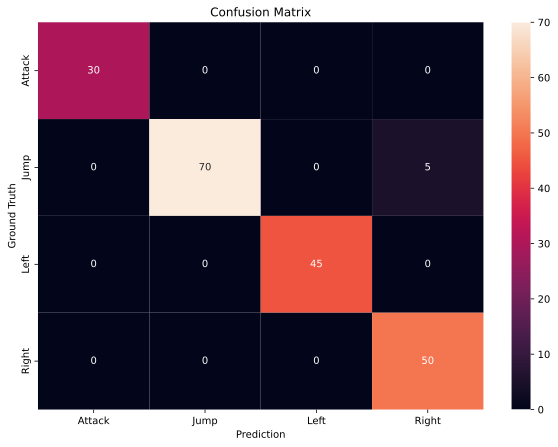

In [149]:
labels = ["Attack", "Jump", "Left", "Right"]

plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d')
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", bbox_inches='tight')
plt.show()

In [150]:
# Add Softmax layer for inference
class ModelWithSoftmax(nn.Module):
    def __init__(self, model):
        super(ModelWithSoftmax, self).__init__()
        self.model = model
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        return x
torchmodel = ModelWithSoftmax(model)

In [151]:
torchmodel

ModelWithSoftmax(
  (model): SimpleTimeSeriesCNN(
    (conv_block): Sequential(
      (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(32, 16, kernel_size=(4,), stride=(3,), padding=(1,))
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (softmax): Softmax(dim=1)
)

In [152]:
from calflops import calculate_flops
batch_size = 1
input_shape = (batch_size, 6, 50)
flops, macs, params = calculate_flops(model=torchmodel,
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("Model FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  3.41 K  
fwd MACs:                                                               64.64 KMACs
fwd FLOPs:                                                              137.924 KFLOPS
fwd+bwd MACs:                                                           193.92 KMACs
fwd+bwd FLOPs:                                                          413.772 KFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each modul

## Model Conversion : pytorch->coreml

In [153]:
torchmodel.eval()

ModelWithSoftmax(
  (model): SimpleTimeSeriesCNN(
    (conv_block): Sequential(
      (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(32, 16, kernel_size=(4,), stride=(3,), padding=(1,))
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (softmax): Softmax(dim=1)
)

In [154]:
# Trace the model with random data.
example_input = torch.rand(1, 6, 50).to(device)
traced_model = torch.jit.trace(torchmodel, example_input)
out = traced_model(example_input)

In [158]:
import coremltools as ct

# Using image_input in the inputs parameter:
mlmodel = ct.convert(
    traced_model,
    convert_to="neuralnetwork",
    inputs=[ct.TensorType(shape=example_input.shape)]
 )
# Save the converted model.
mlmodel.save("newmodel.mlmodel")

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 45/45 [00:00<00:00, 29579.01 ops/s]


In [156]:
print(mlmodel)

# Access the output description
for output in mlmodel.output_description._fd_spec:
    print(output.name, output.type)

input {
  name: "x_1"
  type {
    multiArrayType {
      shape: 1
      shape: 6
      shape: 50
      dataType: FLOAT32
    }
  }
}
output {
  name: "var_61"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "torch==2.3.0+cu121"
  }
  userDefined {
    key: "com.github.apple.coremltools.source_dialect"
    value: "TorchScript"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "7.2"
  }
}

var_61 multiArrayType {
  dataType: FLOAT32
}



## Evaluate CoreML model

In [157]:

def test_tflite_on_onebatch(inputs, labels):
    correct_predictions = 0
    total_predictions = 0

    for i in range(len(inputs)):
        # test_sample = np.array(X_test[i][:3], dtype=np.float32).reshape(input_shape)
        # expected_output = y_test[i]
        test_sample = inputs[i]#.unsqueeze(0)
        expected_output = labels[i]

        input_dict = {'input': test_sample}
        # Make a prediction
        prediction = mlmodel.predict(input_dict)

        predicted_output = np.argmax(prediction)

        if predicted_output == expected_output:
            correct_predictions += 1
        total_predictions += 1

    accuracy = correct_predictions / total_predictions
    # print(f"Model Accuracy: {accuracy:.2f}%")
    return accuracy

ts_list=[]
for inputs, labels in test_loader:
  test_accuracy = test_tflite_on_onebatch(inputs, labels)
  ts_list.append(test_accuracy)

print(f'Test accutacy of CoreML model :{np.mean(ts_list)*100}%')

Exception: Model prediction is only supported on macOS version 10.13 or later.

AVG Runtime: 33.94284 milliseconds

RAM Usage: 9.4K

Flash Usage: 39.1K